In [1]:
import sqlite3
from sqlite3 import Error
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
import numpy as np
%matplotlib inline

# Extract the files
## cat part-* > clicks.gz
## gunzip -c clicks.gz > clicks.json

## cat part-* > transaction.gz
## gunzip -c transaction.gz > transaction.json

## cat part-* > impressions.gz
## gunzip -c impressions.gz > impressions.json

## cat part-* > clicks.gz
## gunzip -c clicks.gz > clicks.json

## Afterwards, the explore.py will be ran to create a charchic.db SQLite database. The file create_tables.sql will be used to create the SQL scheme. All data from the JSON files will be parsed and loaded up into the SQLite database.

# SQLlite connections and functions

In [574]:
#!python explore.py

In [2]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

In [3]:
def make_select(conn,sqlCommand):
    """
    Query all rows in the tasks table
    :param conn: the Connection object
    :return:
    """
    cur = conn.cursor()
    cur.execute(sqlCommand)
 
    rows = cur.fetchall()
 
    for row in rows:
        print(row)

In [4]:
db_file = "chaordic.db"
conn = create_connection(db_file)

In [5]:
# Test database conection
make_select(conn, "Select * From transactions_items Limit 5")

(-8468716808217914046, -2946697713091517060, 99.99, 1)
(103257389481310034, -7444430477752553485, 86.24, 1)
(103257389481310034, -1593531750981905395, 29.99, 1)
(103257389481310034, -1593531750981905395, 29.99, 1)
(998471017524245573, -4553141046227747134, 154.9, 1)


# Load up panda dataframes with SQL data.

In [8]:
sqlLimit = 0 # it is for testing because the datasets are pretty large
def RetSqlLimit(nameSource,limit):
    if limit>0:
        if nameSource=='pageviews':
            return " Limit "+str(limit)
        elif nameSource=='clicks':
            return " Limit "+str(int(limit/25.67035848))
        elif nameSource=='impressions':
            return " Limit "+str(int(limit/1.177091993))
        elif nameSource=='transactions':
            return " Limit "+str(int(limit/278.1644851))
    else:
        return ""
RetSqlLimit('impressions',sqlLimit)

''

In [9]:
clicks = pd.read_sql_query("SELECT * from clicks"+RetSqlLimit("clicks",sqlLimit), conn)
clicks['group'] = clicks['ab'].apply(lambda x: x[:1])
clicks['session'] = clicks['ab'].apply(lambda x: x[2:])

In [10]:
impressions = pd.read_sql_query("SELECT * from impressions"+RetSqlLimit("impressions",sqlLimit), conn)
impressions_products = pd.read_sql_query("SELECT * from impressions_products"+RetSqlLimit("impressions",sqlLimit), conn)
impressions['group'] = impressions['ab'].apply(lambda x: x[:1])
impressions['session'] = impressions['ab'].apply(lambda x: x[2:])

In [11]:
pageviews = pd.read_sql_query("SELECT * from pageviews "+RetSqlLimit("pageviews",sqlLimit), conn)
pageviews_tags = pd.read_sql_query("SELECT * from pageviews_tags "+RetSqlLimit("pageviews",sqlLimit), conn)
pageviews['group'] = pageviews['ab'].apply(lambda x: x[:1])
pageviews['session'] = pageviews['ab'].apply(lambda x: x[2:])

In [12]:
sqlText = '''
Select a.id,a.ab, sum(items_price*items_quantity) as items_total, sum(items_quantity) as total_quantity
  From transactions a, transactions_items b
 Where a.id = b.id
 Group By a.id, a.ab
''' + RetSqlLimit("transactions",sqlLimit)

transactions = pd.read_sql_query(sqlText, conn)
transactions_items = pd.read_sql_query("SELECT * from transactions_items "+RetSqlLimit("transactions",sqlLimit), conn)
transactions['group'] = transactions['ab'].apply(lambda x: x[:1])
transactions['session'] = transactions['ab'].apply(lambda x: x[2:])
transactions_items['items_total'] = transactions_items['items_price']*transactions_items['items_quantity']

transactions.head(5)

,id,ab,items_total,total_quantity,group,session
0,-9223185178483173395,E/585971731795584869,101.98,2,E,585971731795584869
1,-9222261015789277132,A/-5111293127490179813,305.99,1,A,-5111293127490179813
2,-9222187580537061584,F/2564340076839017376,229.99,1,F,2564340076839017376
3,-9222181048618470236,D/-7976297778178387230,174.24,1,D,-7976297778178387230
4,-9221908979709112875,B/-2679500769807275555,99.58,2,B,-2679500769807275555


In [13]:
print("clicks", len(clicks))
print("impressions", len(impressions))
print("impressions_products", len(impressions_products))
print("pageviews", len(pageviews))
print("pageviews_tags", len(pageviews_tags))
print("transactions", len(transactions))
print("transactions_items", len(transactions_items))

clicks 1183002
impressions 25798767
impressions_products 70660912
pageviews 30367518
pageviews_tags 156979276
transactions 109194
transactions_items 179431


In [14]:
impressions.head(2)

,type,feature,vrlId,id,info_browserId,info_browser,info_os,info_geoIPLongitude,info_geoIPLatitude,info_source,ab,page,algRef,my_id,timestamp,group,session
0,viewreclog,-7828424103269057573,8765249957191,8765249957191,2077291510979737164,Chrome Mobile 59.0.3071,Android 4.4.2,-43.2192,-22.8305,mobile,G/7849515658654400358,product,5321418768591000592,1,2017-08-26 00:05:22,G,7849515658654400358
1,viewreclog,5603092165415881620,8765249957191,8765249957191,-5794300198289426830,Chrome Mobile 58.0.3029,Android 4.3,-46.6658,-23.4733,mobile,E/-9206771770294839467,search,8765249957191,2,2017-08-26 00:05:22,E,-9206771770294839467


In [15]:
impressions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25798767 entries, 0 to 25798766
Data columns (total 17 columns):
type                   object
feature                int64
vrlId                  int64
id                     int64
info_browserId         int64
info_browser           object
info_os                object
info_geoIPLongitude    float64
info_geoIPLatitude     float64
info_source            object
ab                     object
page                   object
algRef                 int64
my_id                  int64
timestamp              object
group                  object
session                object
dtypes: float64(2), int64(6), object(9)
memory usage: 3.3+ GB


In [16]:
impressions_products.head(2)

,my_id,products
0,1,3653391013242405988
1,1,3492582560532754791


In [17]:
impressions_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70660912 entries, 0 to 70660911
Data columns (total 2 columns):
my_id       int64
products    int64
dtypes: int64(2)
memory usage: 1.1 GB


In [18]:
pageviews.head(2)

,type,name,id,info_browserId,info_browser,info_os,info_geoIPLongitude,info_geoIPLatitude,info_source,ab,my_id,timestamp,group,session
0,page,category,8765249957191,-8901737309149095989,Firefox Beta 4.0 b12,Linux,None,None,desktop,F/-4674034584350596422,25798768,2017-08-26 12:18:26,F,-4674034584350596422
1,page,category,8765249957191,-6952411218239337506,Chrome Mobile 59.0.3071,Android 5.1.1,None,None,mobile,F/-3370818432877482132,25798769,2017-08-26 12:18:26,F,-3370818432877482132


In [19]:
pageviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30367518 entries, 0 to 30367517
Data columns (total 14 columns):
type                   object
name                   object
id                     int64
info_browserId         int64
info_browser           object
info_os                object
info_geoIPLongitude    object
info_geoIPLatitude     object
info_source            object
ab                     object
my_id                  int64
timestamp              object
group                  object
session                object
dtypes: int64(3), object(11)
memory usage: 3.2+ GB


In [20]:
pageviews_tags.head(2)

,my_id,tags
0,25798768,-5990677861896497487
1,25798768,-5075272788001827571


In [21]:
pageviews_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156979276 entries, 0 to 156979275
Data columns (total 2 columns):
my_id    int64
tags     int64
dtypes: int64(2)
memory usage: 2.3 GB


In [22]:
clicks.head(2)

,type,feature,vrlId,product,id,info_browserId,info_browser,info_os,info_geoIPLongitude,info_geoIPLatitude,info_source,ab,page,timestamp,group,session
0,clicklog,2406596896456549791,-8377820109229386856,6952869018143429188,8765249957191,1865329336598195445,Chrome 60.0.3112,Windows,-122.3341,47.6103,desktop,A/-2433577766061835784,category,2017-09-13 12:58:08,A,-2433577766061835784
1,clicklog,-7828424103269057573,6627298913942488713,-5138915283570447380,8765249957191,3258854675349784616,Chrome Mobile 56.0.2924,Android 6.0.1,-122.3422,47.6344,mobile,A/-621823323795459513,product,2017-09-13 12:08:00,A,-621823323795459513


In [23]:
clicks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1183002 entries, 0 to 1183001
Data columns (total 16 columns):
type                   1183002 non-null object
feature                1183002 non-null int64
vrlId                  1183002 non-null int64
product                1183002 non-null int64
id                     1183002 non-null int64
info_browserId         1183002 non-null int64
info_browser           1183002 non-null object
info_os                1183002 non-null object
info_geoIPLongitude    1163744 non-null float64
info_geoIPLatitude     1163744 non-null float64
info_source            1182991 non-null object
ab                     1183002 non-null object
page                   1183002 non-null object
timestamp              1183002 non-null object
group                  1183002 non-null object
session                1183002 non-null object
dtypes: float64(2), int64(5), object(9)
memory usage: 144.4+ MB


In [24]:
transactions.head(2)

,id,ab,items_total,total_quantity,group,session
0,-9223185178483173395,E/585971731795584869,101.98,2,E,585971731795584869
1,-9222261015789277132,A/-5111293127490179813,305.99,1,A,-5111293127490179813


In [25]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109194 entries, 0 to 109193
Data columns (total 6 columns):
id                109194 non-null int64
ab                109194 non-null object
items_total       109194 non-null float64
total_quantity    109194 non-null int64
group             109194 non-null object
session           109194 non-null object
dtypes: float64(1), int64(2), object(3)
memory usage: 5.0+ MB


In [26]:
transactions_items.head(2)

,id,items_id,items_price,items_quantity,items_total
0,-8468716808217914046,-2946697713091517060,99.99,1,99.99
1,103257389481310034,-7444430477752553485,86.24,1,86.24


In [27]:
transactions_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179431 entries, 0 to 179430
Data columns (total 5 columns):
id                179431 non-null int64
items_id          179431 non-null int64
items_price       179431 non-null float64
items_quantity    179431 non-null int64
items_total       179431 non-null float64
dtypes: float64(2), int64(3)
memory usage: 6.8 MB


In [28]:
# Checking out statistics for transaction order
transactions['items_total'].describe()

count    109194.000000
mean        189.652729
std         404.528557
min           0.950000
25%          83.990000
50%         134.990000
75%         219.990000
max       78399.950000
Name: items_total, dtype: float64

# Page Views schema

In [ ]:
{
    'ab': 'F/-4674034584350596422', # group/session
    'id': 8765249957191, # unique pageView id
    'info': {
        'browser': 'Firefox Beta 4.0 b12', # browser model
        'browserId': -8901737309149095989, # unique browser id (think of this as a user id)
        'geoIPLatitude': None, # latitude reported by the browser
        'geoIPLongitude': None, # longitude reported by the browser
        'os': 'Linux', # operating system
        'source': 'desktop' # type of device (desktop or mobile)
    },
    'name': 'category', # type of page where click happened
    'tags': [-5990677861896497487, -5075272788001827571], # special tags set by our customers for each page.
    'timestamp': '2017-08-26 12:18:26', # event time
    'type': 'page' # type of event
}

# it is being created a new data frame for holding visitor data. It was considered the feature session. 

In [29]:
#visitors = pageviews[['session','info_browserId','info_browser','info_os','info_source','timestamp']][:]
#visitors = pageviews[['session','info_browserId','timestamp']][:]
#visitors = pageviews[['group','session','timestamp']][:]
visitors = pageviews[['group','session','info_browserId','info_browser','info_os','info_source']][:]
#visitors['date'] = visitors['timestamp'].apply(lambda x: x[:10])
#del visitors['timestamp']

def first_word(string):
    pos = string.find(' ')
    if pos>=0:
        return string[:pos]
    else:
        return string

visitors['os'] = visitors['info_os'].apply(first_word)
visitors['browser'] = visitors['info_browser'].apply(first_word)

visitors = visitors.drop_duplicates()

In [34]:
print ("There {} rows in page views and {} rows in the visitors, using unique visitors by day".format(len(pageviews),len(visitors))) 
print ("Therefore, we've got {} pageviews by visitor".format(round(len(pageviews)/len(visitors),2)))
print ("The number of visitors above should be {} but there is something wrong in the data ".format(len(pageviews.session.unique())))

There 30367518 rows in page views and 3845964 rows in the visitors, using unique visitors by day
Therefore, we've got 7.9 pageviews by visitor
The number of visitors above should be 3727520 but there is something wrong in the data 


In [35]:
visitors.head(5)

,group,session,info_browserId,info_browser,info_os,info_source,os,browser
0,F,-4674034584350596422,-8901737309149095989,Firefox Beta 4.0 b12,Linux,desktop,Linux,Firefox
1,F,-3370818432877482132,-6952411218239337506,Chrome Mobile 59.0.3071,Android 5.1.1,mobile,Android,Chrome
2,H,-6833017977536873480,-7304148636562131161,Chrome Mobile 60.0.3112,Android 6.0,mobile,Android,Chrome
3,G,-5201470044805936293,-5836905034004402498,Chrome 60.0.3112,Windows 8,desktop,Windows,Chrome
4,E,-2183580581788687574,7440345113969891771,Chrome Mobile 60.0.3112,Android 6.0,mobile,Android,Chrome


In [32]:
first_date_pageviews = pageviews['timestamp'].min()
last_date_pageviews = pageviews['timestamp'].max()

In [33]:
print ("first_date_pageviews", first_date_pageviews)
print ("last_date_pageviews", last_date_pageviews)

first_date_pageviews 2017-08-26 00:00:00
last_date_pageviews 2017-09-18 12:00:10


# Check out missing values

In [36]:
vars_with_missing = []

for f in impressions.columns:
    missings = impressions[impressions[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/impressions.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

vars_with_missing = []

for f in pageviews.columns:
    missings = pageviews[pageviews[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/pageviews.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

vars_with_missing = []

for f in transactions.columns:
    missings = transactions[transactions[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/transactions.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

for f in clicks.columns:
    missings = clicks[clicks[f] == -1][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/clicks.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

In total, there are 0 variables with missing values
In total, there are 0 variables with missing values
In total, there are 0 variables with missing values
In total, there are 0 variables with missing values


# Check out distinct data values

In [37]:
v = ['info_source','name','type']

for f in v:
    dist_values = pageviews[f].value_counts().shape[0]
    print('pageviews - Variable {} has {} distinct values'.format(f, dist_values))
    
v = ['algRef','feature','page','type']

for f in v:
    dist_values = impressions[f].value_counts().shape[0]
    print('impressions - Variable {} has {} distinct values'.format(f, dist_values))


pageviews - Variable info_source has 2 distinct values
pageviews - Variable name has 9 distinct values
pageviews - Variable type has 1 distinct values
impressions - Variable algRef has 12 distinct values
impressions - Variable feature has 12 distinct values
impressions - Variable page has 7 distinct values
impressions - Variable type has 1 distinct values


In [41]:
'''
Revenue per visitor = revenue / visitors
Conversion = transactions / visitors
Average order value (AOV) = revenue / transactions
'''
number_of_clicks = len(clicks)
number_of_pageviews = len(pageviews)
number_of_visitors = len(visitors)
number_of_impressions = len(impressions)
number_of_transactions = len(transactions)
revenue = transactions['items_total'].sum()

print ("Revenue per visitor = ${:,.2f}".format(revenue / number_of_visitors))
print ("Conversion = transactions / visitors = {:,.2f}".format(number_of_transactions / number_of_visitors))
print ("Average order value (AOV) = revenue / transactions = ${:,.2f}".format(revenue / number_of_transactions))

print()
print("Total of revenue ${:,.2f}".format(revenue))
print("number_of_pageviews {:,.2f} ".format(number_of_pageviews))
print("number_of_impressions {:,.2f} ".format(number_of_impressions))
print("number_of_visitors {:,.2f} ".format(number_of_visitors))
print("number_of_clicks {:,.2f} ".format(number_of_clicks))
print("number_of_transactions {:,.2f} ".format(number_of_transactions))

Revenue per visitor = $5.38
Conversion = transactions / visitors = 0.03
Average order value (AOV) = revenue / transactions = $189.65

Total of revenue $20,708,940.06
number_of_pageviews 30,367,518.00 
number_of_impressions 25,798,767.00 
number_of_visitors 3,845,964.00 
number_of_clicks 1,183,002.00 
number_of_transactions 109,194.00 


In [43]:
impressions_by_group = pd.DataFrame(impressions.groupby(['group'])['session'].count())
impressions_by_group.columns.values[0] = 'impressions'

clicks_by_group = pd.DataFrame(clicks.groupby(['group'])['session'].count())
clicks_by_group.columns.values[0] = 'clicks'

transactions_by_group = pd.DataFrame(transactions.groupby(['group'])['session'].count())
transactions_by_group.columns.values[0] = 'transactions'

quantity_by_group = pd.DataFrame(transactions.groupby(['group'])['total_quantity'].sum())
quantity_by_group.columns.values[0] = 'quantity'

revenue_by_group = pd.DataFrame(transactions.groupby(['group'])['items_total'].sum())
revenue_by_group.columns.values[0] = 'revenue'

visitors_by_group = pd.DataFrame(visitors.groupby(['group'])['session'].count())
visitors_by_group.columns.values[0] = 'visits'

funnel_by_group = impressions_by_group.join(visitors_by_group).join(clicks_by_group).join(transactions_by_group).join(quantity_by_group).join(revenue_by_group)
funnel_by_group['CTR'] = funnel_by_group['clicks']/funnel_by_group['impressions']
funnel_by_group['Conversion'] = funnel_by_group['transactions']/funnel_by_group['visits']
funnel_by_group['Quantity by Transaction'] = funnel_by_group['quantity']/funnel_by_group['transactions']

funnel_by_group['AOV'] = funnel_by_group['revenue']/funnel_by_group['transactions']
funnel_by_group['Revenue by visits'] = funnel_by_group['revenue']/funnel_by_group['visits']


funnel_by_group = funnel_by_group.sort_values(by='CTR', ascending=False)

In [44]:
funnel_by_group

,impressions,visits,clicks,transactions,quantity,revenue,CTR,Conversion,Quantity by Transaction,AOV,Revenue by visits
group,,,,,,,,,,,
A,3157151,480847,149664,13703,22280,2565705.21,0.047405,0.028498,1.625921,187.236752,5.335804
B,3167199,481575,149936,13562,22412,2461017.10,0.047340,0.028162,1.652559,181.464172,5.110351
E,3233634,481743,148761,14001,23251,2765632.60,0.046004,0.029063,1.660667,197.531076,5.740888
F,3180758,480508,145964,13305,21554,2588891.64,0.045890,0.027689,1.619992,194.580356,5.387822
G,3235507,480727,146324,12982,21316,2381157.67,0.045224,0.027005,1.641966,183.419941,4.953243
C,3293588,479970,148723,13558,22245,2665391.63,0.045155,0.028248,1.640729,196.591800,5.553246
D,3271689,480703,147253,14000,22992,2628788.12,0.045008,0.029124,1.642286,187.770580,5.468633
H,3259241,479891,146377,14083,23381,2652356.09,0.044911,0.029346,1.660229,188.337434,5.526997


In [45]:
impressions_by_algRef = pd.DataFrame(impressions.groupby(['algRef'])['session'].count())
impressions_by_algRef.columns.values[0] = 'impressions'
impressions_by_algRef = impressions_by_algRef.sort_values(by='impressions', ascending=False)
impressions_by_algRef

,impressions
algRef,
5321418768591000592,7720606
8765249957191,7139996
-7316380623456322413,6364701
-4036572744233045313,3228956
-8097938104232819077,597978
6210645274200748928,219459
-2694931237408746828,199717
8912499131073959470,166706
-5699424829365636926,157505


I was not able to track how many clicks it got from each algorithm because the feature 'id' on impressions is not a unique value like it is reported on https://github.com/chaordic/machinelearning-challenge/blob/master/dswa-challenge.ipynb. Therefore it is not possible to join impressions feature 'id' and clicks feature 'vrlId'. Other features not unique are bellow:

In [46]:
print ("The feature 'id' is not unique on pagaviews",len(pageviews.id.unique()))
print ("The feature 'id' is not unique on impressions",len(impressions.id.unique()))
print ("The feature 'id' is not unique on clicks",len(clicks.id.unique()))
print ("I would use the feature 'vrlId' on clicks to join with its respective impression, but the feature 'id' on impression is not unique",len(clicks.vrlId.unique()))

The feature 'id' is not unique on pagaviews 1
The feature 'id' is not unique on impressions 1
The feature 'id' is not unique on clicks 1
I would use the feature 'vrlId' on clicks to join with its respective impression, but the feature 'id' on impression is not unique 1078648


# Plot data

In [47]:
def plot_barchat(x,y,bar_type,y_label,title):

    y_pos = np.arange(len(x))
 
    if bar_type=="v":
        plt.bar(y_pos, y, align='center', alpha=0.5)
        plt.xticks(y_pos, x)
    else:
        plt.barh(y_pos, y, align='center', alpha=0.5)
        plt.yticks(y_pos, x)

    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

# Sessions

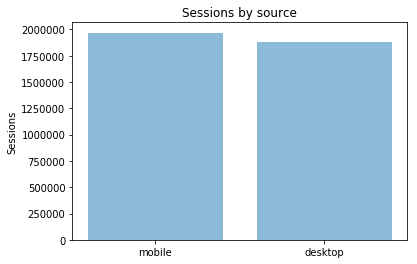

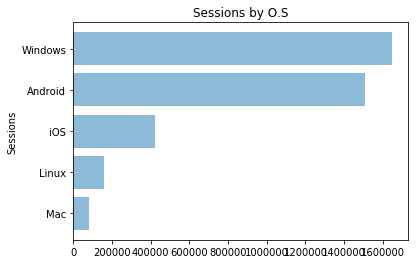

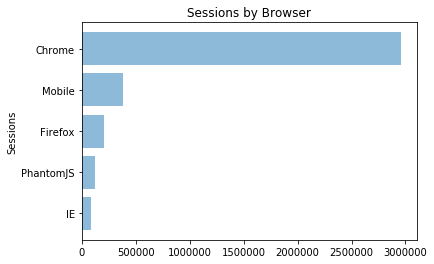

In [48]:
visitors_by = pd.DataFrame(visitors.groupby(['info_source'])['info_source'].count())
visitors_by = visitors_by.sort_values(by='info_source', ascending=False)
x_plot = list(visitors_by.index)
y_plot = list(visitors_by['info_source'])
plot_barchat(x_plot,y_plot,'v','Sessions','Sessions by source')

visitors_by = pd.DataFrame(visitors.groupby(['os'])['os'].count().nlargest(5))
visitors_by = visitors_by.sort_values(by='os', ascending=True)
x_plot = list(visitors_by.index)
y_plot = list(visitors_by['os'])
plot_barchat(x_plot,y_plot,'h','Sessions','Sessions by O.S')

visitors_by = pd.DataFrame(visitors.groupby(['browser'])['browser'].count().nlargest(5))
visitors_by = visitors_by.sort_values(by='browser', ascending=True)
x_plot = list(visitors_by.index)
y_plot = list(visitors_by['browser'])
plot_barchat(x_plot,y_plot,'h','Sessions','Sessions by Browser')

# Funnel

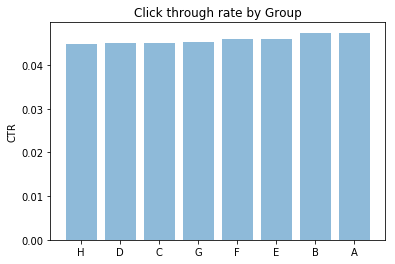

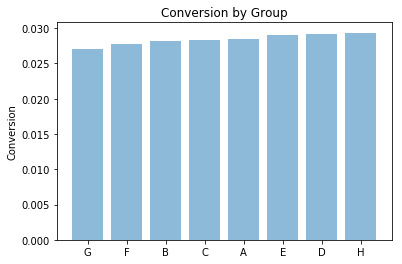

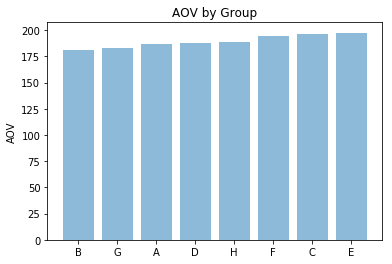

In [49]:
funnel_by_group = funnel_by_group.sort_values(by='CTR', ascending=True)
x_plot = funnel_by_group.index
y_plot = funnel_by_group['CTR']
plot_barchat(x_plot,y_plot,'v','CTR','Click through rate by Group')

funnel_by_group = funnel_by_group.sort_values(by='Conversion', ascending=True)
x_plot = funnel_by_group.index
y_plot = funnel_by_group['Conversion']
plot_barchat(x_plot,y_plot,'v','Conversion','Conversion by Group')

funnel_by_group = funnel_by_group.sort_values(by='AOV', ascending=True)
x_plot = funnel_by_group.index
y_plot = funnel_by_group['AOV']
plot_barchat(x_plot,y_plot,'v','AOV','AOV by Group')

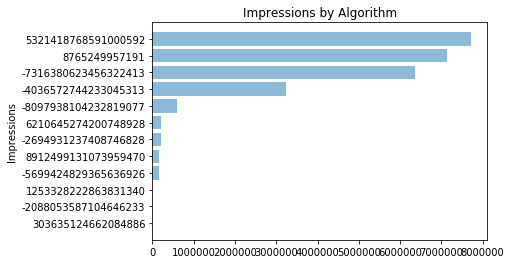

I could not figure out how many clicks a algorithm got because I did not find a link between both observations.
If I had found a feature in order to relate impressions and clicks, I would have done a better algorithm evaluation through CTR


In [50]:
impressions_by_algRef = impressions_by_algRef.sort_values(by='impressions', ascending=True)
x_plot = impressions_by_algRef.index
y_plot = impressions_by_algRef['impressions']
plot_barchat(x_plot,y_plot,'h','Impressions','Impressions by Algorithm')
print("I could not figure out how many clicks a algorithm got because I did not find a link between both observations.")
print("If I had found a feature in order to relate impressions and clicks, I would have done a better algorithm evaluation through CTR")

# Best seller products 

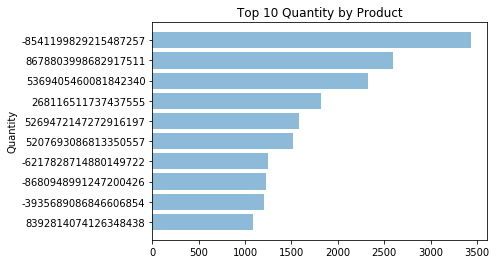

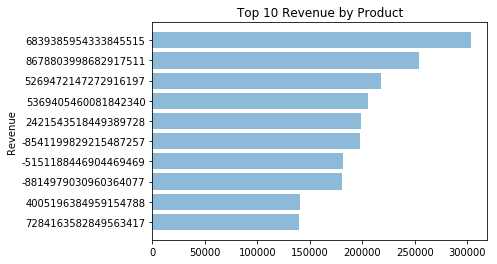

In [51]:
transactions_by = pd.DataFrame(transactions_items.groupby(['items_id'])['items_quantity'].sum().nlargest(10))
transactions_by = transactions_by.sort_values(by='items_quantity', ascending=True)
x_plot = list(transactions_by.index)
y_plot = list(transactions_by['items_quantity'])
plot_barchat(x_plot,y_plot,'h','Quantity','Top 10 Quantity by Product')

transactions_by = pd.DataFrame(transactions_items.groupby(['items_id'])['items_total'].sum().nlargest(10))
transactions_by = transactions_by.sort_values(by='items_total', ascending=True)
x_plot = list(transactions_by.index)
y_plot = list(transactions_by['items_total'])
plot_barchat(x_plot,y_plot,'h','Revenue','Top 10 Revenue by Product')

# Product with more impressions

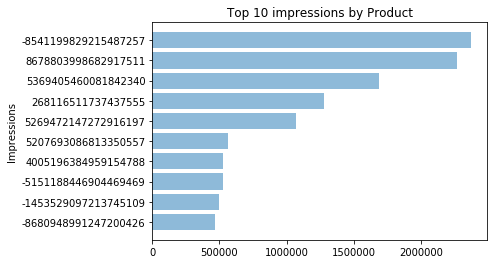

In [52]:
impressions_by = pd.DataFrame(impressions_products.groupby(['products'])['products'].count().nlargest(10))
impressions_by = impressions_by.sort_values(by='products', ascending=True)
x_plot = list(impressions_by.index)
y_plot = list(impressions_by['products'])
plot_barchat(x_plot,y_plot,'h','Impressions','Top 10 impressions by Product')

# Map